In [ ]:
# Importing lib
import pandas as pd
import lightgbm as lgb
import numpy as np
from sklearn.metrics import roc_auc_score, average_precision_score
from category_encoders import TargetEncoder
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, FunctionTransformer
from sklearn.model_selection import GridSearchCV
from sklearn.impute import SimpleImputer
import seaborn as sns
import matplotlib.pyplot as plt
import joblib

In [93]:
#Loading Master Labelled Data and dropping potential data leak features
df_labeled=pd.read_csv("../Processed Data/prd_loyal_customers.csv")
df_labeled.drop(columns=['is_repeat_customer', 'is_repeat_customer', 'days_since_last_order','is_first_order'], inplace=True)
df = df_labeled.copy()

FEATURE ENGINEERING FOR ENHANCED SIGNALS FOR ML MODELLING

To improve the model's ability to distinguish between repeat and non-repeat customers, I performed iterative feature engineering. By analyzing feature importance from multiple model runs, I developed a set of behavioral and economic signals. These features are designed to capture patterns in historical data for established repeaters while providing 'look-alike' signals to identify high-potential first-time customers

The definition of Metrics are:


1) sentiment_index: A numerical score capturing the customer’s satisfaction by weighting review scores against comment lengths or sentiment.

2) state_avg: The historical average order value for the customer's geographic region, representing local purchasing power.

3) cat_avg: The typical order value for a specific product category, used as a benchmark for "normal" spending behavior.

4) value_ratio: The ratio of a customer’s spend compared to the global average, identifying high-value vs. budget shoppers.

5) val_ratio_vs_category: Measures how much more (or less) a customer spent on a product compared to that category's typical price point.

6) freight_ordervalue_ratio: The percentage of the total cost spent on shipping, used to detect if high delivery fees deter repeat purchases.

7) price_spread_ratio: The variance between the highest and lowest-priced items in a single order, indicating "basket diversity."

8) order_value_spread_ratio: Measures the fluctuation in total spending across different orders to identify consistent vs. erratic spenders.

9) weight_spread_ratio: Captures the variation in physical weight of items ordered, distinguishing between bulk buyers and small-item shoppers.

10) volume_spread_ratio: Measures the variation in the physical dimensions (size) of items purchased to understand logistical complexity per customer.

In [94]:
score = df["avg_review_score"].fillna(-1)
length = df["avg_review_length"].fillna(0)
conditions = [
    (score >= 4) & (length > 0),                    # 5: Vocal Promoter
    (score >= 4) & (length == 0),                   # 4: Silent Satisfied
    (score == -1),                                  # 3: Ghost
    (score > 2) & (score < 4),                      # 2: Passive
    (score <= 2) & (score > 0) & (length == 0),     # 1: Quiet Detractor
    (score <= 2) & (score > 0) & (length > 0)       # 0: Vocal Detractor
]
choices = [5, 4, 3, 2, 1, 0]
df["sentiment_index"] = np.select(conditions, choices, default=3).astype(int)
df = df.drop(columns=["avg_review_length"], errors="ignore")

In [95]:
df = df_labeled.copy()
df["snapshot_date"] = pd.to_datetime(df["snapshot_date"], errors="coerce")
split_point = df["snapshot_date"].quantile(0.8)

train_idx = df["snapshot_date"] < split_point
test_idx  = df["snapshot_date"] >= split_point

In [96]:
df["main_category"] = df["main_category"].fillna("unknown").astype(str)

state_lookup = df.loc[train_idx].groupby("customer_state")["total_order_value"].mean()
cat_lookup   = df.loc[train_idx].groupby("main_category")["total_order_value"].mean()
global_avg   = df.loc[train_idx, "total_order_value"].mean()

df["state_avg"] = df["customer_state"].map(state_lookup).fillna(global_avg)
df["cat_avg"]   = df["main_category"].map(cat_lookup).fillna(global_avg)

df["value_ratio"]           = df["total_order_value"] / df["state_avg"]
df["val_ratio_vs_category"] = df["total_order_value"] / df["cat_avg"]
df["freight_ordervalue_ratio"] = df["total_freight_value"] / df["total_order_value"].replace(0, np.nan)

Instead of just having Min/Max as Features, it is better to take ratios of these features and derive new features. 

Reason: Tree Models like LightBGM, XGBoost etc, are better with ratios (for splits)

In [97]:
eps = 1e-6

df["price_spread_ratio"]      = df["max_price"] / (df["min_price"] + eps)
df["order_value_spread_ratio"]= df["max_order_value"] / (df["min_order_value"] + eps)

df["weight_spread_ratio"]     = df["max_weight"] / (df["avg_weight"] + eps)   
df["volume_spread_ratio"]     = df["max_volume"] / (df["avg_volume"] + eps)

In [98]:
for c in ["price_spread_ratio","order_value_spread_ratio","weight_spread_ratio","volume_spread_ratio"]:
    df[c] = df[c].clip(upper=50)  

In [99]:
# List of columns to drop
drop_cols = [
    'label_is_loyal','customer_id', 'order_id', 'customer_unique_id','order_purchase_timestamp', 'snapshot_date','past_order_count',        
    'customer_city','min_price', 'max_price','min_order_value', 'max_order_value','max_weight', 'max_volume', 'min_review_score', 'max_review_score', 
    'geolocation_lat', 'geolocation_lng', "is_latlng_missing","customer_state","customer_zip_code_prefix","total_freight_value","avg_freight_value",
    "total_order_value","state_avg","total_payment_value","tot_sellers_in_zip","tot_customers_in_zip","min_items","max_items"
]

X = df.drop(columns=drop_cols, errors='ignore')
y = df['label_is_loyal']

print(X.select_dtypes(include=['object']).columns)

Index(['main_category'], dtype='object')


TRAIN-TEST SPLIT BASED ON TIMELINE. --> Train on Historical Data and Test on New Data

In [100]:
# Splitting data based on Timeline i.e. Old Data for Training the Models and New Data For Testing the generalizale ability

df["snapshot_date"] = pd.to_datetime(df_labeled["snapshot_date"], errors="coerce")
df = df.sort_values("snapshot_date").copy()

test_cutoff = df["snapshot_date"].quantile(0.8)
val_cutoff = df["snapshot_date"].quantile(0.6)

train_idx = df["snapshot_date"] < val_cutoff
val_idx   = (df["snapshot_date"] >= val_cutoff) & (df["snapshot_date"] < test_cutoff)
test_idx  = df["snapshot_date"] >= test_cutoff

X_train, y_train = X[train_idx].copy(), y[train_idx].copy()
X_val,   y_val   = X[val_idx].copy(),   y[val_idx].copy()
X_test,  y_test  = X[test_idx].copy(),  y[test_idx].copy()

print(f"Training Range: {df.loc[train_idx, 'snapshot_date'].min()} to {df.loc[train_idx, 'snapshot_date'].max()}")
print(f"Test Range:     {df.loc[test_idx, 'snapshot_date'].min()} to {df.loc[test_idx, 'snapshot_date'].max()}")

Training Range: 2016-09-03 21:15:19 to 2018-03-01 13:34:44
Test Range:     2018-05-23 18:04:31 to 2018-08-28 15:00:37


/var/folders/jr/cx9v05mj76767q_pxc111nvr0000gn/T/ipykernel_53024/3480058269.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  X_train, y_train = X[train_idx].copy(), y[train_idx].copy()
/var/folders/jr/cx9v05mj76767q_pxc111nvr0000gn/T/ipykernel_53024/3480058269.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  X_val,   y_val   = X[val_idx].copy(),   y[val_idx].copy()
/var/folders/jr/cx9v05mj76767q_pxc111nvr0000gn/T/ipykernel_53024/3480058269.py:15: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  X_test,  y_test  = X[test_idx].copy(),  y[test_idx].copy()


MAIN CATEGORY: This categorical feature was transformed using Target Encoding with a smoothing factor to represent each product category by its historical conversion probability, effectively capturing the "loyalty potential" inherent to different product types.

In [ ]:
te = TargetEncoder(cols=["main_category"], smoothing=5)
X_train["main_category"] = te.fit_transform(X_train["main_category"], y_train)

X_val["main_category"] = te.transform(X_val["main_category"])
X_test["main_category"] = te.transform(X_test["main_category"])

X_train["main_category"] = X_train["main_category"].fillna(y_train.mean())
X_val["main_category"]   = X_val["main_category"].fillna(y_train.mean())
X_test["main_category"]  = X_test["main_category"].fillna(y_train.mean())

In [102]:
print("Loyalty score for top categories in Train:")
print(X_train["main_category"].value_counts().head())

Loyalty score for top categories in Train:
main_category
0.061299    5514
0.049468    4609
0.041834    4470
0.041250    3903
0.058486    3830
Name: count, dtype: int64


<h2> LOGISTIC REGRESSION <h2>

### CORRELATION MATRIX ###

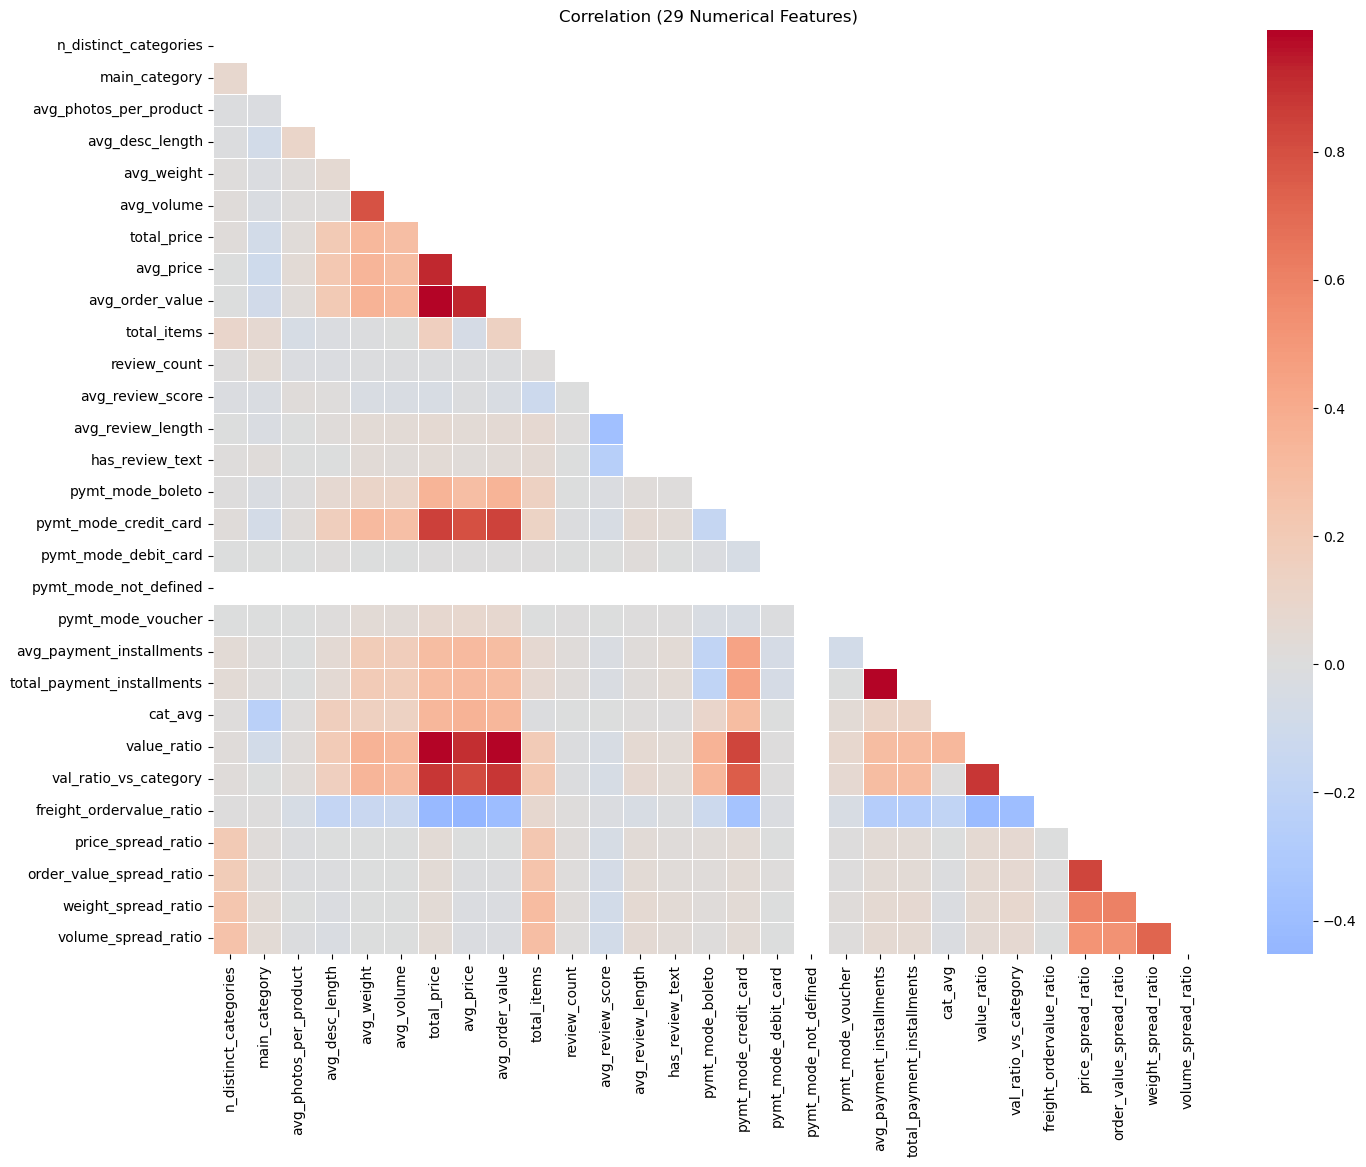

Highly Correlated Pairs (>0.8):
                        level_0                     level_1         0
175                 total_price                   avg_price  0.924239
176                 total_price             avg_order_value  0.989665
183                 total_price       pymt_mode_credit_card  0.851982
189                 total_price                 value_ratio  0.988223
190                 total_price       val_ratio_vs_category  0.885989
202                   avg_price                 total_price  0.924239
204                   avg_price             avg_order_value  0.923825
217                   avg_price                 value_ratio  0.905183
218                   avg_price       val_ratio_vs_category  0.814153
230             avg_order_value                 total_price  0.989665
231             avg_order_value                   avg_price  0.923825
239             avg_order_value       pymt_mode_credit_card  0.844941
245             avg_order_value                 value_rati

In [ ]:
raw_corr = X_train.select_dtypes(include=['number']).corr()


plt.figure(figsize=(16, 12))
mask = np.triu(np.ones_like(raw_corr, dtype=bool))

sns.heatmap(raw_corr, mask=mask, annot=False, cmap='coolwarm', center=0, linewidths=.5)
plt.title("Correlation (29 Numerical Features)")
plt.show()


high_corr = raw_corr.stack().reset_index()
high_corr = high_corr[high_corr[0].between(0.8, 0.999)] # Filter for high correlation but not self-correlation
print("Highly Correlated Pairs (>0.8):")
print(high_corr)

In [104]:
# List of redundant features identified in the Correlation Analysis
cols_to_drop = [
    'avg_price',               
    'avg_order_value',         
    'value_ratio',             
    'val_ratio_vs_category',            
    'avg_payment_installments', 
    'order_value_spread_ratio'  
]
# Dropping from all sets to maintain consistency
X_train = X_train.drop(columns=cols_to_drop)
X_test = X_test.drop(columns=cols_to_drop)
X_val = X_val.drop(columns=cols_to_drop)

print(f"Features removed: {len(cols_to_drop)}")
print(f"New Feature Count: {X_train.shape[1]}")

Features removed: 6
New Feature Count: 23


Fixing Skewness and Scaling of Features

In [ ]:
skew_limit = 1.0
skewed_feats = X_train.select_dtypes(include=['number']).skew()
log_cols = skewed_feats[abs(skewed_feats) > skew_limit].index.tolist()


log_indices = [X_train.columns.get_loc(c) for c in log_cols]


# We Impute (fill NaNs) -> Log Transform -> Standard Scale
preprocessor = ColumnTransformer(
    transformers=[
        ('log', FunctionTransformer(np.log1p), log_indices)
    ],
    remainder='passthrough' # Keep columns that didn't need log
)

# why Median for Imputing Values 
# Logistic Regression is sensitive to outliers. If you have skewed features (like total_price or freight_value), 
# the Mean can be heavily pulled by extreme values, leading to "biased" imputations that don't represent the typical customer.
# Median is "positional"—it represents the middle of the pack regardless of how far out the outliers are. It preserves the central 
# tendency better in the "Power Law" distributions.

lr_final_pipe = Pipeline([
    ('imputer', SimpleImputer(strategy='median')), 
    ('prep', preprocessor),
    ('scaler', StandardScaler()), 
    ('model', LogisticRegression(class_weight='balanced', solver='liblinear', C=1.0))
])


lr_final_pipe.fit(X_train, y_train)

,"steps steps: list of tuplesList of (name of step, estimator) tuples that are to be chained insequential order. To be compatible with the scikit-learn API, all stepsmust define `fit`. All non-last steps must also define `transform`. See:ref:`Combining Estimators ` for more details.","[('imputer', ...), ('prep', ...), ...]"
,"transform_input transform_input: list of str, default=NoneThe names of the :term:`metadata` parameters that should be transformed by thepipeline before passing it to the step consuming it.This enables transforming some input arguments to ``fit`` (other than ``X``)to be transformed by the steps of the pipeline up to the step which requiresthem. Requirement is defined via :ref:`metadata routing `.For instance, this can be used to pass a validation set through the pipeline.You can only set this if metadata routing is enabled, which youcan enable using ``sklearn.set_config(enable_metadata_routing=True)``... versionadded:: 1.6",None
,"memory memory: str or object with the joblib.Memory interface, default=NoneUsed to cache the fitted transformers of the pipeline. The last stepwill never be cached, even if it is a transformer. By default, nocaching is performed. If a string is given, it is the path to thecaching directory. Enabling caching triggers a clone of the transformersbefore fitting. Therefore, the transformer instance given to thepipeline cannot be inspected directly. Use the attribute ``named_steps``or ``steps`` to inspect estimators within the pipeline. Caching thetransformers is advantageous when fitting is time consuming. See:ref:`sphx_glr_auto_examples_neighbors_plot_caching_nearest_neighbors.py`for an example on how to enable caching.",None
,"verbose verbose: bool, default=FalseIf True, the time elapsed while fitting each step will be printed as itis completed.",False
,"missing_values missing_values: int, float, str, np.nan, None or pandas.NA, default=np.nanThe placeholder for the missing values. All occurrences of`missing_values` will be imputed. For pandas' dataframes withnullable integer dtypes with missing values, `missing_values`can be set to either `np.nan` or `pd.NA`.",nan
,"strategy strategy: str or Callable, default='mean'The imputation strategy.- If ""mean"", then replace missing values using the mean along each column. Can only be used with numeric data.- If ""median"", then replace missing values using the median along each column. Can only be used with numeric data.- If ""most_frequent"", then replace missing using the most frequent value along each column. Can be used with strings or numeric data. If there is more than one such value, only the smallest is returned.- If ""constant"", then replace missing values with fill_value. Can be used with strings or numeric data.- If an instance of Callable, then replace missing values using the scalar statistic returned by running the callable over a dense 1d array containing non-missing values of each column... versionadded:: 0.20 strategy=""constant"" for fixed value imputation... versionadded:: 1.5 strategy=callable for custom value imputation.",'median'
,"fill_value fill_value: str or numerical value, default=NoneWhen strategy == ""constant"", `fill_value` is used to replace alloccurrences of missing_values. For string or object data types,`fill_value` must be a string.If `None`, `fill_value` will be 0 when imputing numericaldata and ""missing_value"" for strings or object data types.",None
,"copy copy: bool, default=TrueIf True, a copy of X will be created. If False, imputation willbe done in-place whenever possible. Note that, in the following cases,a new copy will always be made, even if `copy=False`:- If `X` is not an array of floating values;- If `X` is encoded as a CSR matrix;- If `add_indicator=True`.",True
,"add_indicator add_indicator: bool, default=FalseIf True, a :class:`MissingIndicator` transform will stack onto outputof the imputer's transform. This allows a predictive estimatorto account for missingness despite imputation. If 

In [106]:
log_cols

['n_distinct_categories',
 'avg_photos_per_product',
 'avg_desc_length',
 'avg_weight',
 'avg_volume',
 'total_price',
 'total_items',
 'review_count',
 'avg_review_score',
 'avg_review_length',
 'pymt_mode_boleto',
 'pymt_mode_credit_card',
 'pymt_mode_debit_card',
 'pymt_mode_voucher',
 'total_payment_installments',
 'cat_avg',
 'freight_ordervalue_ratio',
 'price_spread_ratio',
 'weight_spread_ratio',
 'volume_spread_ratio']

### HYPERPARAM SELECTION USING GRIDSEARCHCV ###

In [ ]:
param_grid = {
    'model__C': [0.001, 0.01, 0.1, 1, 10, 100],
    # We remove penalty from here to keep it at the default 'l2' 
    # and just tune the strength 'C'
}

grid_classifier = GridSearchCV(
    lr_final_pipe, 
    param_grid, 
    cv=5, 
    scoring='roc_auc',
    n_jobs=-1 # Speeds it up by using all CPU cores
)

grid_classifier.fit(X_train, y_train)
print(f"Best C value: {grid_classifier.best_params_['model__C']}")

Best C value: 0.01


In [107]:
lr_final_pipe.fit(X_train, y_train)

y_pred = lr_final_pipe.predict(X_test)
y_proba = lr_final_pipe.predict_proba(X_test)[:, 1]

<Figure size 600x500 with 0 Axes>

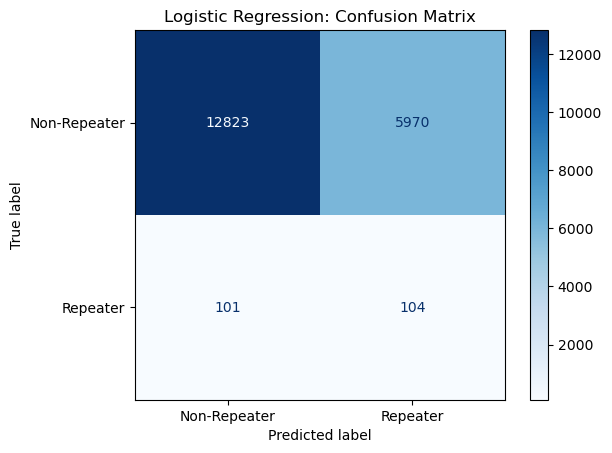

In [108]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6, 5))
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Non-Repeater', 'Repeater'])
disp.plot(cmap='Blues', values_format='d')
plt.title("Logistic Regression: Confusion Matrix")
plt.show()

Our baseline model successfully identifies 50% of all repeat customers (Recall). However, because repeaters are so rare in our data, for every 1 true repeater we find, we currently target about 58 non-repeaters. This is a great starting point for a baseline, but it's why we are moving toward XGBoost and LightGBM to see if we can reduce those 5,969 false alarms."

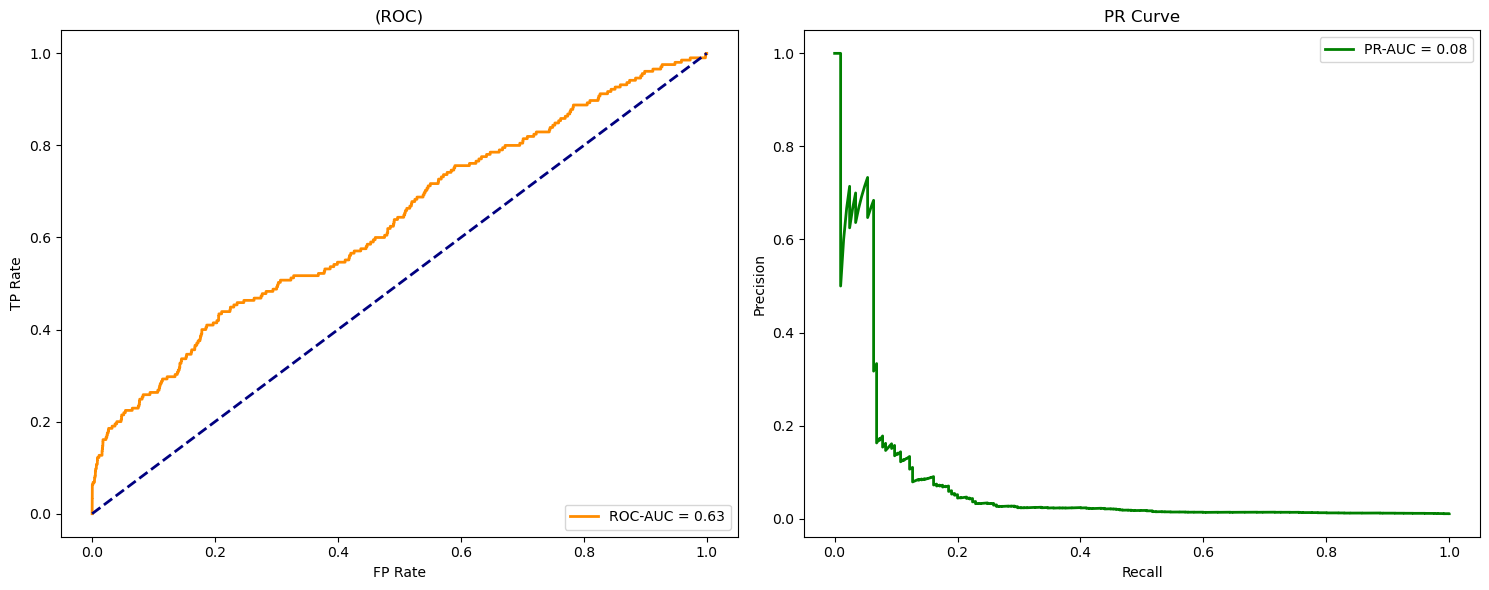

In [109]:
from sklearn.metrics import roc_curve, auc, precision_recall_curve, average_precision_score

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

# ROC Curve
fpr, tpr, _ = roc_curve(y_test, y_proba)
roc_auc = auc(fpr, tpr)
ax1.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC-AUC = {roc_auc:.2f}')
ax1.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
ax1.set_title('(ROC)')
ax1.set_xlabel('FP Rate')
ax1.set_ylabel('TP Rate')
ax1.legend(loc="lower right")

# PR Curve
precision, recall, _ = precision_recall_curve(y_test, y_proba)
pr_auc = average_precision_score(y_test, y_proba)
ax2.plot(recall, precision, color='green', lw=2, label=f'PR-AUC = {pr_auc:.2f}')
ax2.set_title('PR Curve')
ax2.set_xlabel('Recall')
ax2.set_ylabel('Precision')
ax2.legend(loc="upper right")

plt.tight_layout()
plt.show()

In [110]:
from sklearn.metrics import f1_score, roc_auc_score, average_precision_score

y_pred = lr_final_pipe.predict(X_test)
y_probs = lr_final_pipe.predict_proba(X_test)[:, 1]


roc_auc = roc_auc_score(y_test, y_probs)
pr_auc = average_precision_score(y_test, y_probs)
f1 = f1_score(y_test, y_pred)


print("LOGISTIC Regression: KEY PERFORMANCE")
print("="*40)
print(f"{'ROC-AUC Score:':<20} {roc_auc:.4f}")
print(f"{'PR-AUC Score:':<20} {pr_auc:.4f}")
print(f"{'F1-Score:':<20} {f1:.4f}")
print("="*40)

LOGISTIC Regression: KEY PERFORMANCE
ROC-AUC Score:       0.6338
PR-AUC Score:        0.0765
F1-Score:            0.0331


ROC-AUC (0.6328): The model has a moderate ability to rank a random repeater higher than a random non-repeater. It has "learned" something, but it isn't strong enough yet to be the sole driver for expensive marketing campaigns.

PR-AUC (0.0765): This is the most critical metric here. If your raw data only has, say, 3% repeaters, then a score of 0.07 means you are roughly 2.5x better than random guessing, but your precision drops off very quickly as you try to find more customers (Recall).

F1-Score (0.0325): This very low score indicates that the "Optimal" threshold for Logistic Regression is struggling to find a balance. The model is likely being too conservative or too aggressive, failing to capture repeaters without letting in too many false alarms.

Feature Importance

/var/folders/jr/cx9v05mj76767q_pxc111nvr0000gn/T/ipykernel_53024/3847750418.py:16: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=importance_df, x='Coefficient', y='Feature', palette='RdBu_r')


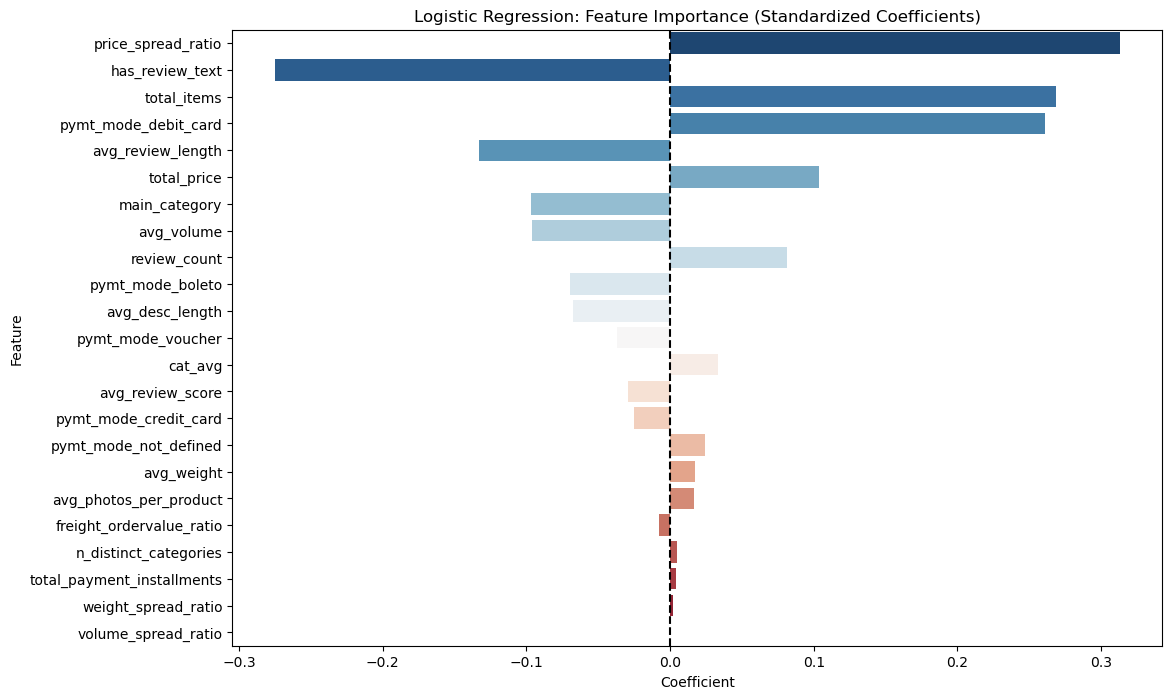

In [111]:
lr_model = lr_final_pipe.named_steps['model']

feature_names = X_train.columns

importance_df = pd.DataFrame({
    'Feature': feature_names,
    'Coefficient': lr_model.coef_[0]
})


importance_df['Abs_Weight'] = importance_df['Coefficient'].abs()
importance_df = importance_df.sort_values(by='Abs_Weight', ascending=False)


plt.figure(figsize=(12, 8))
sns.barplot(data=importance_df, x='Coefficient', y='Feature', palette='RdBu_r')
plt.title("Logistic Regression: Feature Importance (Standardized Coefficients)")
plt.axvline(0, color='black', linestyle='--')
plt.show()

<h2> LIGHT BGM <h2>

### Evaluating Best Param using Randomized Search ###

In [129]:
from sklearn.model_selection import RandomizedSearchCV

random_search = RandomizedSearchCV(
    lgbm_pipe, 
    param_distributions=param_grid, 
    n_iter=20,     # It will only try 20 random combinations
    cv=3,          # Reduced folds from 5 to 3
    scoring='roc_auc', 
    verbose=1, 
    n_jobs=-1      # Uses all your CPU cores
)
random_search.fit(X_train, y_train)

Fitting 3 folds for each of 20 candidates, totalling 60 fits
[LightGBM] [Info] Number of positive: 1529, number of negative: 36467
[LightGBM] [Info] Number of positive: 1529, number of negative: 36467
[LightGBM] [Info] Number of positive: 1529, number of negative: 36467
[LightGBM] [Info] Number of positive: 1528, number of negative: 36468
[LightGBM] [Info] Number of positive: 1529, number of negative: 36467
[LightGBM] [Info] Number of positive: 1529, number of negative: 36467
[LightGBM] [Info] Number of positive: 1528, number of negative: 36468
[LightGBM] [Info] Number of positive: 1529, number of negative: 36467
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.005702 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.005858 seconds.
You can set `force_row_wise=true` to remove the o

,"estimator estimator: estimator objectAn object of that type is instantiated for each grid point.This is assumed to implement the scikit-learn estimator interface.Either estimator needs to provide a ``score`` function,or ``scoring`` must be passed.",Pipeline(step...m_state=50))])
,"param_distributions param_distributions: dict or list of dictsDictionary with parameters names (`str`) as keys and distributionsor lists of parameters to try. Distributions must provide a ``rvs``method for sampling (such as those from scipy.stats.distributions).If a list is given, it is sampled uniformly.If a list of dicts is given, first a dict is sampled uniformly, andthen a parameter is sampled using that dict as above.","{'model__learning_rate': [0.01, 0.05, ...], 'model__max_depth': [-1, 10, ...], 'model__min_child_samples': [10, 20, ...], 'model__n_estimators': [100, 200, ...], ...}"
,"n_iter n_iter: int, default=10Number of parameter settings that are sampled. n_iter tradesoff runtime vs quality of the solution.",20
,"scoring scoring: str, callable, list, tuple or dict, default=NoneStrategy to evaluate the performance of the cross-validated model onthe test set.If `scoring` represents a single score, one can use:- a single string (see :ref:`scoring_string_names`);- a callable (see :ref:`scoring_callable`) that returns a single value;- `None`, the `estimator`'s :ref:`default evaluation criterion ` is used.If `scoring` represents multiple scores, one can use:- a list or tuple of unique strings;- a callable returning a dictionary where the keys are the metric names and the values are the metric scores;- a dictionary with metric names as keys and callables as values.See :ref:`multimetric_grid_search` for an example.If None, the estimator's score method is used.",'roc_auc'
,"n_jobs n_jobs: int, default=NoneNumber of jobs to run in parallel.``None`` means 1 unless in a :obj:`joblib.parallel_backend` context.``-1`` means using all processors. See :term:`Glossary `for more details... versionchanged:: v0.20 `n_jobs` default changed from 1 to None",-1
,"refit refit: bool, str, or callable, default=TrueRefit an estimator using the best found parameters on the wholedataset.For multiple metric evaluation, this needs to be a `str` denoting thescorer that would be used to find the best parameters for refittingthe estimator at the end.Where there are considerations other than maximum score inchoosing a best estimator, ``refit`` can be set to a function whichreturns the selected ``best_index_`` given the ``cv_results_``. In thatcase, the ``best_estimator_`` and ``best_params_`` will be setaccording to the returned ``best_index_`` while the ``best_score_``attribute will not be available.The refitted estimator is made available at the ``best_estimator_``attribute and permits using ``predict`` directly on this``RandomizedSearchCV`` instance.Also for multiple metric evaluation, the attributes ``best_index_``,``best_score_`` and ``best_params_`` will only be available if``refit`` is set and all of them will be determined w.r.t this specificscorer.See ``scoring`` parameter to know more about multiple metricevaluation.See :ref:`this example`for an example of how to use ``refit=callable`` to balance modelcomplexity and cross-validated score... versionchanged:: 0.20 Support for callable added.",True
,"cv cv: int, cross-validation generator or an iterable, default=NoneDetermines the cross-validation splitting strategy.Possible inputs for cv are:- None, to use the default 5-fold cross validation,- integer, to specify the number of folds in a `(Stratified)KFold`,- :term:`CV splitter`,- An iterable yielding (train, test) splits as arrays of indices.For integer/None inputs, if the estimator is a classifier and ``y`` iseither binary or multiclass, :class:`StratifiedKFold` is used. In allother cases, :class:`KFold` is used. These splitters are instantiatedwith `shuffle=False` so the splits will be the same across calls.Refer :ref:`User Guide ` for the variouscross-validatio

In [130]:
print(f"Best Score (ROC-AUC): {random_search.best_score_:.4f}")
print("Best Parameters found:")
for param, value in random_search.best_params_.items():
    print(f"  {param}: {value}")

# Set your final model to the best one found
best_lgbm = random_search.best_estimator_

Best Score (ROC-AUC): 0.6346
Best Parameters found:
  model__num_leaves: 15
  model__n_estimators: 200
  model__min_child_samples: 30
  model__max_depth: 10
  model__learning_rate: 0.01


In [ ]:
import lightgbm as lgb
from sklearn.pipeline import Pipeline


# We use 'is_unbalance=True' because our repeaters are the minority class
lgbm_model = lgb.LGBMClassifier(
    n_estimators=200,
    learning_rate=0.01,
    num_leaves=15,
    is_unbalance=True, 
    random_state=50,
    importance_type='gain' 
)

lgbm_pipe = Pipeline([
    ('model', lgbm_model)
])

lgbm_pipe.fit(X_train, y_train)

In [ ]:
import lightgbm as lgb
from sklearn.pipeline import Pipeline


# We use 'is_unbalance=True' because our repeaters are the minority class
lgbm_model = lgb.LGBMClassifier(
    n_estimators=200,
    learning_rate=0.01,
    num_leaves=15,
    is_unbalance=True, 
    random_state=50,
    importance_type='gain' 
)

lgbm_pipe = Pipeline([
    ('model', lgbm_model)
])

lgbm_pipe.fit(X_train, y_train)

[LightGBM] [Info] Number of positive: 2293, number of negative: 54701
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002053 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3447
[LightGBM] [Info] Number of data points in the train set: 56994, number of used features: 22
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.040232 -> initscore=-3.172021
[LightGBM] [Info] Start training from score -3.172021


,"steps steps: list of tuplesList of (name of step, estimator) tuples that are to be chained insequential order. To be compatible with the scikit-learn API, all stepsmust define `fit`. All non-last steps must also define `transform`. See:ref:`Combining Estimators ` for more details.","[('model', ...)]"
,"transform_input transform_input: list of str, default=NoneThe names of the :term:`metadata` parameters that should be transformed by thepipeline before passing it to the step consuming it.This enables transforming some input arguments to ``fit`` (other than ``X``)to be transformed by the steps of the pipeline up to the step which requiresthem. Requirement is defined via :ref:`metadata routing `.For instance, this can be used to pass a validation set through the pipeline.You can only set this if metadata routing is enabled, which youcan enable using ``sklearn.set_config(enable_metadata_routing=True)``... versionadded:: 1.6",None
,"memory memory: str or object with the joblib.Memory interface, default=NoneUsed to cache the fitted transformers of the pipeline. The last stepwill never be cached, even if it is a transformer. By default, nocaching is performed. If a string is given, it is the path to thecaching directory. Enabling caching triggers a clone of the transformersbefore fitting. Therefore, the transformer instance given to thepipeline cannot be inspected directly. Use the attribute ``named_steps``or ``steps`` to inspect estimators within the pipeline. Caching thetransformers is advantageous when fitting is time consuming. See:ref:`sphx_glr_auto_examples_neighbors_plot_caching_nearest_neighbors.py`for an example on how to enable caching.",None
,"verbose verbose: bool, default=FalseIf True, the time elapsed while fitting each step will be printed as itis completed.",False
,boosting_type,'gbdt'
,num_leaves,15
,max_depth,-1
,learning_rate,0.01
,n_estimators,100
,subsample_for_bin,200000
,objective,None


In [113]:

lgbm_preds = lgbm_pipe.predict(X_test)
lgbm_probs = lgbm_pipe.predict_proba(X_test)[:, 1]


from sklearn.metrics import f1_score, roc_auc_score, average_precision_score

lgbm_roc = roc_auc_score(y_test, lgbm_probs)
lgbm_pr = average_precision_score(y_test, lgbm_probs)
lgbm_f1 = f1_score(y_test, lgbm_preds)

print("="*40)
print("LIGHTGBM: KEY PERFORMANCE")
print("="*40)
print(f"{'ROC-AUC Score:':<20} {lgbm_roc:.4f}")
print(f"{'PR-AUC Score:':<20} {lgbm_pr:.4f}")
print(f"{'F1-Score:':<20} {lgbm_f1:.4f}")
print("="*40)

LIGHTGBM: KEY PERFORMANCE
ROC-AUC Score:       0.6141
PR-AUC Score:        0.0610
F1-Score:            0.1156


While Logistic Regression maintains a slightly higher ROC-AUC, LightGBM achieved a significantly better F1-Score (0.115). This indicates that the tree-based model is more effective at balancing Precision and Recall at the default threshold, making it a more practical choice for targeted marketing actions

/var/folders/jr/cx9v05mj76767q_pxc111nvr0000gn/T/ipykernel_53024/323812484.py:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=lgbm_importance_df.head(15), x='Importance', y='Feature', palette='magma')


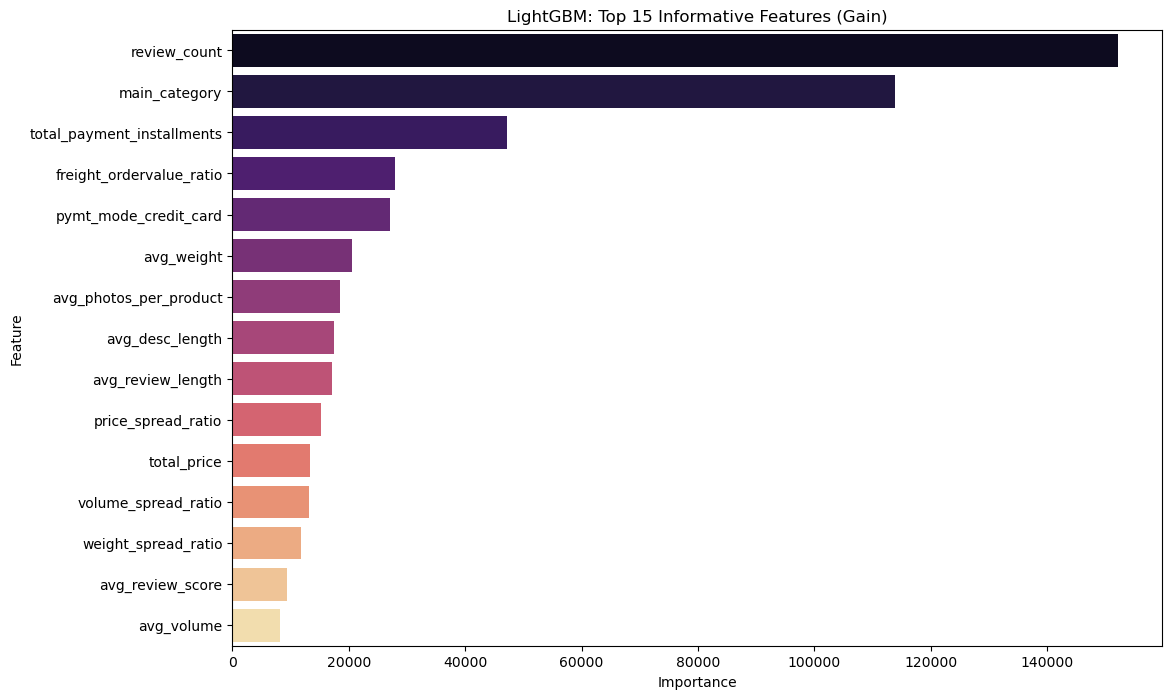

In [114]:

importance = lgbm_pipe.named_steps['model'].booster_.feature_importance(importance_type='gain')
feature_names = X_train.columns

lgbm_importance_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': importance
}).sort_values(by='Importance', ascending=False)

plt.figure(figsize=(12, 8))
sns.barplot(data=lgbm_importance_df.head(15), x='Importance', y='Feature', palette='magma')
plt.title("LightGBM: Top 15 Informative Features (Gain)")
plt.show()

## XGBoost ##

In [131]:
from sklearn.model_selection import RandomizedSearchCV
import numpy as np

# Define the grid for XGBoost
param_grid_xgb = {
    'model__n_estimators': [100, 200, 400],
    'model__learning_rate': [0.01, 0.05, 0.1],
    'model__max_depth': [3, 5, 8],
    'model__scale_pos_weight': [5, 10, 20], # Testing different levels of "aggression"
    'model__gamma': [0, 0.1, 0.5],          # Minimum loss reduction to make a split
    'model__subsample': [0.8, 1.0]          # Percentage of data used per tree
}

# Setup Randomized Search
random_search_xgb = RandomizedSearchCV(
    xgb_pipe, 
    param_distributions=param_grid_xgb, 
    n_iter=15, 
    cv=3, 
    scoring='roc_auc', 
    verbose=1, 
    n_jobs=-1,
    random_state=42
)

# Fit
random_search_xgb.fit(X_train, y_train)

print(f"Best XGB Score: {random_search_xgb.best_score_:.4f}")
print(f"Best XGB Params: {random_search_xgb.best_params_}")

best_xgb_clf = random_search_xgb.best_estimator_

Fitting 3 folds for each of 15 candidates, totalling 45 fits


/opt/anaconda3/lib/python3.12/site-packages/xgboost/training.py:199: UserWarning: [03:06:28] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/anaconda3/lib/python3.12/site-packages/xgboost/training.py:199: UserWarning: [03:06:28] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/anaconda3/lib/python3.12/site-packages/xgboost/training.py:199: UserWarning: [03:06:28] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/anaconda3/lib/python3.12/site-packages/xgboost/training.py:199: UserWarning: [03:06:28] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i

Best XGB Score: 0.6423
Best XGB Params: {'model__subsample': 0.8, 'model__scale_pos_weight': 10, 'model__n_estimators': 400, 'model__max_depth': 3, 'model__learning_rate': 0.01, 'model__gamma': 0.1}


In [ ]:
from xgboost import XGBClassifier
from sklearn.pipeline import Pipeline

xgb_model_optimized = XGBClassifier(
    n_estimators=400,       
    learning_rate=0.01,     
    max_depth=3,            
    scale_pos_weight=10,     
    subsample=0.8,           
    gamma=0.1,              
    reg_alpha=0.1,          
    reg_lambda=1.0,         
    use_label_encoder=False,
    eval_metric='logloss',
    random_state=42
)

xgb_pipe_final = Pipeline([
    ('model', xgb_model_optimized)
])

xgb_pipe_final.fit(X_train, y_train)


/opt/anaconda3/lib/python3.12/site-packages/xgboost/training.py:199: UserWarning: [03:09:58] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


,"steps steps: list of tuplesList of (name of step, estimator) tuples that are to be chained insequential order. To be compatible with the scikit-learn API, all stepsmust define `fit`. All non-last steps must also define `transform`. See:ref:`Combining Estimators ` for more details.","[('model', ...)]"
,"transform_input transform_input: list of str, default=NoneThe names of the :term:`metadata` parameters that should be transformed by thepipeline before passing it to the step consuming it.This enables transforming some input arguments to ``fit`` (other than ``X``)to be transformed by the steps of the pipeline up to the step which requiresthem. Requirement is defined via :ref:`metadata routing `.For instance, this can be used to pass a validation set through the pipeline.You can only set this if metadata routing is enabled, which youcan enable using ``sklearn.set_config(enable_metadata_routing=True)``... versionadded:: 1.6",None
,"memory memory: str or object with the joblib.Memory interface, default=NoneUsed to cache the fitted transformers of the pipeline. The last stepwill never be cached, even if it is a transformer. By default, nocaching is performed. If a string is given, it is the path to thecaching directory. Enabling caching triggers a clone of the transformersbefore fitting. Therefore, the transformer instance given to thepipeline cannot be inspected directly. Use the attribute ``named_steps``or ``steps`` to inspect estimators within the pipeline. Caching thetransformers is advantageous when fitting is time consuming. See:ref:`sphx_glr_auto_examples_neighbors_plot_caching_nearest_neighbors.py`for an example on how to enable caching.",None
,"verbose verbose: bool, default=FalseIf True, the time elapsed while fitting each step will be printed as itis completed.",False
,"objective objective: typing.Union[str, xgboost.sklearn._SklObjWProto, typing.Callable[[typing.Any, typing.Any], typing.Tuple[numpy.ndarray, numpy.ndarray]], NoneType]Specify the learning task and the corresponding learning objective or a customobjective function to be used.For custom objective, see :doc:`/tutorials/custom_metric_obj` and:ref:`custom-obj-metric` for more information, along with the end note forfunction signatures.",'binary:logistic'
,"base_score base_score: typing.Union[float, typing.List[float], NoneType]The initial prediction score of all instances, global bias.",None
,booster,None
,"callbacks callbacks: typing.Optional[typing.List[xgboost.callback.TrainingCallback]]List of callback functions that are applied at end of each iteration.It is possible to use predefined callbacks by using:ref:`Callback API `... note:: States in callback are not preserved during training, which means callback objects can not be reused for multiple training sessions without reinitialization or deepcopy... code-block:: python for params in parameters_grid: # be sure to (re)initialize the callbacks before each run callbacks = [xgb.callback.LearningRateScheduler(custom_rates)] reg = xgboost.XGBRegressor(**params, callbacks=callbacks) reg.fit(X, y)",None
,colsample_bylevel colsample_bylevel: typing.Optional[float]Subsample ratio of columns for each level.,None
,colsample_bynode colsample_bynode: typing.Optional[float]Subsample ratio of columns for each split.,None
,colsample_bytree colsample_bytree: typing.Optional[float]Subsample ratio of columns when constructing each tree.,None


In [135]:
xgb_preds = xgb_pipe.predict(X_test)
xgb_probs = xgb_pipe.predict_proba(X_test)[:, 1]

xgb_roc = roc_auc_score(y_test, xgb_probs)
xgb_pr = average_precision_score(y_test, xgb_probs)
xgb_f1 = f1_score(y_test, xgb_preds)

print("="*40)
print("XGBOOST: KEY PERFORMANCE")
print("="*40)
print(f"{'ROC-AUC Score:':<20} {xgb_roc:.4f}")
print(f"{'PR-AUC Score:':<20} {xgb_pr:.4f}")
print(f"{'F1-Score:':<20} {xgb_f1:.4f}")
print("="*40)

XGBOOST: KEY PERFORMANCE
ROC-AUC Score:       0.6239
PR-AUC Score:        0.0810
F1-Score:            0.1201


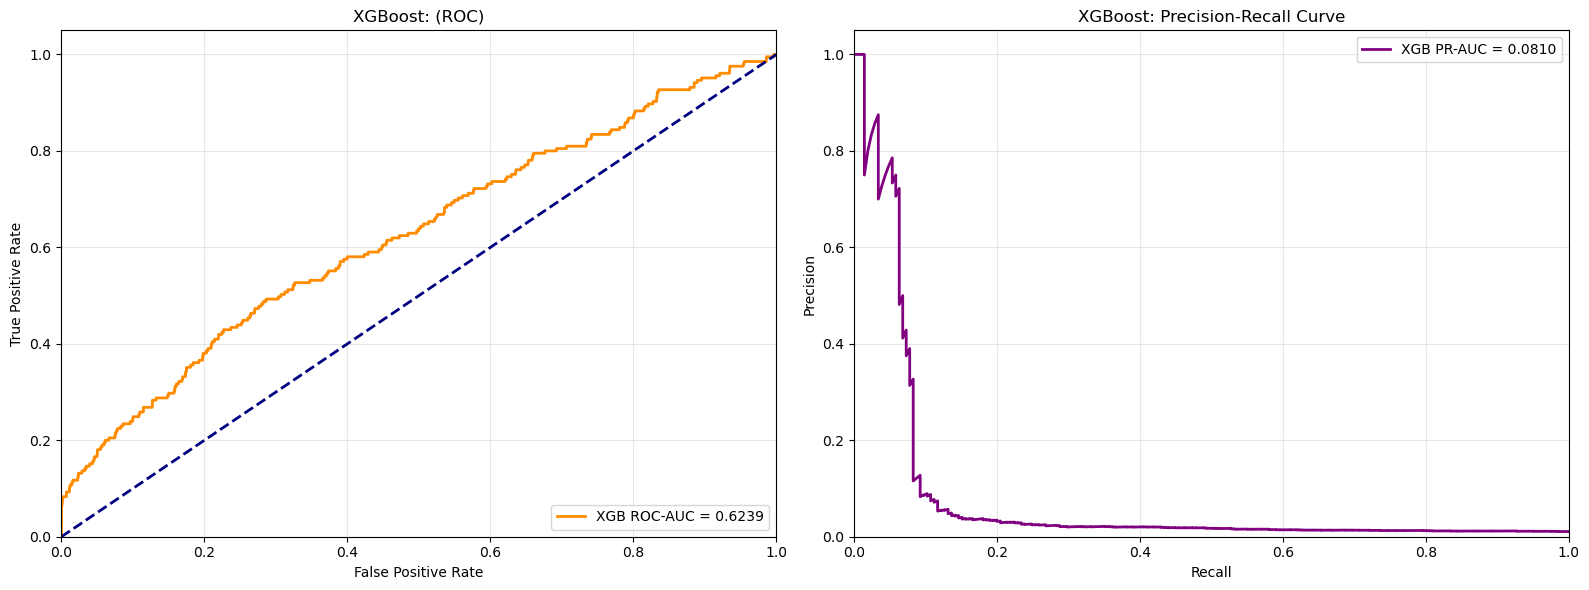

In [117]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc, precision_recall_curve, average_precision_score


fpr, tpr, _ = roc_curve(y_test, xgb_probs)
roc_auc = auc(fpr, tpr)

precision, recall, _ = precision_recall_curve(y_test, xgb_probs)
pr_auc = average_precision_score(y_test, xgb_probs)


fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))


ax1.plot(fpr, tpr, color='darkorange', lw=2, label=f'XGB ROC-AUC = {roc_auc:.4f}')
ax1.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
ax1.set_xlim([0.0, 1.0])
ax1.set_ylim([0.0, 1.05])
ax1.set_xlabel('False Positive Rate')
ax1.set_ylabel('True Positive Rate')
ax1.set_title('XGBoost: (ROC)')
ax1.legend(loc="lower right")
ax1.grid(alpha=0.3)

# Plot Precision-Recall Curve
ax2.plot(recall, precision, color='purple', lw=2, label=f'XGB PR-AUC = {pr_auc:.4f}')
ax2.set_xlim([0.0, 1.0])
ax2.set_ylim([0.0, 1.05])
ax2.set_xlabel('Recall')
ax2.set_ylabel('Precision')
ax2.set_title('XGBoost: Precision-Recall Curve')
ax2.legend(loc="upper right")
ax2.grid(alpha=0.3)

plt.tight_layout()
plt.show()

<h2> Random Forest <h2>

In [118]:
from sklearn.ensemble import RandomForestClassifier

# 1. Define the Random Forest model
# 'balanced_subsample' is a powerful way to handle your 3% repeater rate
rf_model = RandomForestClassifier(
    n_estimators=200,
    max_depth=10,             
    min_samples_leaf=20,       
    class_weight='balanced_subsample', 
    random_state=42,
    n_jobs=-1                
)

rf_pipe = Pipeline([
    ('model', rf_model)
])

rf_pipe.fit(X_train, y_train)

,"steps steps: list of tuplesList of (name of step, estimator) tuples that are to be chained insequential order. To be compatible with the scikit-learn API, all stepsmust define `fit`. All non-last steps must also define `transform`. See:ref:`Combining Estimators ` for more details.","[('model', ...)]"
,"transform_input transform_input: list of str, default=NoneThe names of the :term:`metadata` parameters that should be transformed by thepipeline before passing it to the step consuming it.This enables transforming some input arguments to ``fit`` (other than ``X``)to be transformed by the steps of the pipeline up to the step which requiresthem. Requirement is defined via :ref:`metadata routing `.For instance, this can be used to pass a validation set through the pipeline.You can only set this if metadata routing is enabled, which youcan enable using ``sklearn.set_config(enable_metadata_routing=True)``... versionadded:: 1.6",None
,"memory memory: str or object with the joblib.Memory interface, default=NoneUsed to cache the fitted transformers of the pipeline. The last stepwill never be cached, even if it is a transformer. By default, nocaching is performed. If a string is given, it is the path to thecaching directory. Enabling caching triggers a clone of the transformersbefore fitting. Therefore, the transformer instance given to thepipeline cannot be inspected directly. Use the attribute ``named_steps``or ``steps`` to inspect estimators within the pipeline. Caching thetransformers is advantageous when fitting is time consuming. See:ref:`sphx_glr_auto_examples_neighbors_plot_caching_nearest_neighbors.py`for an example on how to enable caching.",None
,"verbose verbose: bool, default=FalseIf True, the time elapsed while fitting each step will be printed as itis completed.",False
,"n_estimators n_estimators: int, default=100The number of trees in the forest... versionchanged:: 0.22 The default value of ``n_estimators`` changed from 10 to 100 in 0.22.",200
,"criterion criterion: {""gini"", ""entropy"", ""log_loss""}, default=""gini""The function to measure the quality of a split. Supported criteria are""gini"" for the Gini impurity and ""log_loss"" and ""entropy"" both for theShannon information gain, see :ref:`tree_mathematical_formulation`.Note: This parameter is tree-specific.",'gini'
,"max_depth max_depth: int, default=NoneThe maximum depth of the tree. If None, then nodes are expanded untilall leaves are pure or until all leaves contain less thanmin_samples_split samples.",10
,"min_samples_split min_samples_split: int or float, default=2The minimum number of samples required to split an internal node:- If int, then consider `min_samples_split` as the minimum number.- If float, then `min_samples_split` is a fraction and `ceil(min_samples_split * n_samples)` are the minimum number of samples for each split... versionchanged:: 0.18 Added float values for fractions.",2
,"min_samples_leaf min_samples_leaf: int or float, default=1The minimum number of samples required to be at a leaf node.A split point at any depth will only be considered if it leaves atleast ``min_samples_leaf`` training samples in each of the left andright branches. This may have the effect of smoothing the model,especially in regression.- If int, then consider `min_samples_leaf` as the minimum number.- If float, then `min_samples_leaf` is a fraction and `ceil(min_samples_leaf * n_samples)` are the minimum number of samples for each node... versionchanged:: 0.18 Added float values for fractions.",20
,"min_weight_fraction_leaf min_weight_fraction_leaf: float, default=0.0The minimum weighted fraction of the sum total of weights (of allthe input samples) required to be at a leaf node. Samples haveequal weight when sample_weight is not provided.",0.0
,"max_features max_features: {""sqrt"", ""log2"", None}, int or float, default=""sqrt""The number of features to consider when looking for the best split:- If int, then consider `max_features` features at each split.- If f

In [119]:

rf_preds = rf_pipe.predict(X_test)
rf_probs = rf_pipe.predict_proba(X_test)[:, 1]


rf_roc = roc_auc_score(y_test, rf_probs)
rf_pr = average_precision_score(y_test, rf_probs)
rf_f1 = f1_score(y_test, rf_preds)

print("="*40)
print("RANDOM FOREST: KEY PERFORMANCE")
print("="*40)
print(f"{'ROC-AUC Score:':<20} {rf_roc:.4f}")
print(f"{'PR-AUC Score:':<20} {rf_pr:.4f}")
print(f"{'F1-Score:':<20} {rf_f1:.4f}")
print("="*40)

RANDOM FOREST: KEY PERFORMANCE
ROC-AUC Score:       0.6045
PR-AUC Score:        0.0756
F1-Score:            0.0393


ENSEMBLE

In [120]:
from sklearn.ensemble import VotingClassifier

ensemble_model = VotingClassifier(
    estimators=[
        ('lr', lr_final_pipe),
        ('lgbm', lgbm_pipe),
        ('xgb', xgb_pipe),
        ('rf', rf_pipe)
    ],
    voting='soft', # 'soft' uses averaged probabilities
    weights=[2, 1, 2, 1] # Giving more weight to LR and XGB based on ROC-AUC
)

# Fit the ensemble
ensemble_model.fit(X_train, y_train)

[LightGBM] [Info] Number of positive: 2293, number of negative: 54701
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000871 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3447
[LightGBM] [Info] Number of data points in the train set: 56994, number of used features: 22
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.040232 -> initscore=-3.172021
[LightGBM] [Info] Start training from score -3.172021


/opt/anaconda3/lib/python3.12/site-packages/xgboost/training.py:199: UserWarning: [02:32:42] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


,"estimators estimators: list of (str, estimator) tuplesInvoking the ``fit`` method on the ``VotingClassifier`` will fit clonesof those original estimators that will be stored in the class attribute``self.estimators_``. An estimator can be set to ``'drop'`` using:meth:`set_params`... versionchanged:: 0.21 ``'drop'`` is accepted. Using None was deprecated in 0.22 and support was removed in 0.24.","[('lr', ...), ('lgbm', ...), ...]"
,"voting voting: {'hard', 'soft'}, default='hard'If 'hard', uses predicted class labels for majority rule voting.Else if 'soft', predicts the class label based on the argmax ofthe sums of the predicted probabilities, which is recommended foran ensemble of well-calibrated classifiers.",'soft'
,"weights weights: array-like of shape (n_classifiers,), default=NoneSequence of weights (`float` or `int`) to weight the occurrences ofpredicted class labels (`hard` voting) or class probabilitiesbefore averaging (`soft` voting). Uses uniform weights if `None`.","[2, 1, ...]"
,"n_jobs n_jobs: int, default=NoneThe number of jobs to run in parallel for ``fit``.``None`` means 1 unless in a :obj:`joblib.parallel_backend` context.``-1`` means using all processors. See :term:`Glossary `for more details... versionadded:: 0.18",None
,"flatten_transform flatten_transform: bool, default=TrueAffects shape of transform output only when voting='soft'If voting='soft' and flatten_transform=True, transform method returnsmatrix with shape (n_samples, n_classifiers * n_classes). Ifflatten_transform=False, it returns(n_classifiers, n_samples, n_classes).",True
,"verbose verbose: bool, default=FalseIf True, the time elapsed while fitting will be printed as itis completed... versionadded:: 0.23",False
,"missing_values missing_values: int, float, str, np.nan, None or pandas.NA, default=np.nanThe placeholder for the missing values. All occurrences of`missing_values` will be imputed. For pandas' dataframes withnullable integer dtypes with missing values, `missing_values`can be set to either `np.nan` or `pd.NA`.",nan
,"strategy strategy: str or Callable, default='mean'The imputation strategy.- If ""mean"", then replace missing values using the mean along each column. Can only be used with numeric data.- If ""median"", then replace missing values using the median along each column. Can only be used with numeric data.- If ""most_frequent"", then replace missing using the most frequent value along each column. Can be used with strings or numeric data. If there is more than one such value, only the smallest is returned.- If ""constant"", then replace missing values with fill_value. Can be used with strings or numeric data.- If an instance of Callable, then replace missing values using the scalar statistic returned by running the callable over a dense 1d array containing non-missing values of each column... versionadded:: 0.20 strategy=""constant"" for fixed value imputation... versionadded:: 1.5 strategy=callable for custom value imputation.",'median'
,"fill_value fill_value: str or numerical value, default=NoneWhen strategy == ""constant"", `fill_value` is used to replace alloccurrences of missing_values. For string or object data types,`fill_value` must be a string.If `None`, `fill_value` will be 0 when imputing numericaldata and ""missing_value"" for strings or object data types.",None
,"copy copy: bool, default=TrueIf True, a copy of X will be created. If False, imputation willbe done in-place whenever possible. Note that, in the following cases,a new copy will always be made, even if `copy=False`:- If `X` is not an array of floating values;- If `X` is encoded as a CSR matrix;- If `add_indicator=True`.",True
,"add_indicator add_indicator: bool, default=FalseIf True, a :class:`MissingIndicator` transform will stack onto outputof the imputer's transform. This allows a predictive estimatorto account for missingness despite imputation. If a feature has nomissing values at fit/train time, the feature won't appear onthe missing indicator even

In [121]:
# 1. Predictions
ens_preds = ensemble_model.predict(X_test)
ens_probs = ensemble_model.predict_proba(X_test)[:, 1]

# 2. Calculate Metrics
ens_roc = roc_auc_score(y_test, ens_probs)
ens_pr = average_precision_score(y_test, ens_probs)
ens_f1 = f1_score(y_test, ens_preds)

print("="*40)
print("ENSEMBLE: KEY PERFORMANCE")
print("="*40)
print(f"{'ROC-AUC Score:':<20} {ens_roc:.4f}")
print(f"{'PR-AUC Score:':<20} {ens_pr:.4f}")
print(f"{'F1-Score:':<20} {ens_f1:.4f}")
print("="*40)

ENSEMBLE: KEY PERFORMANCE
ROC-AUC Score:       0.6282
PR-AUC Score:        0.0831
F1-Score:            0.0688


In [122]:

results_df = pd.DataFrame({
    'Actual': y_test,
    'Prob_Repeat': ens_probs
})


top = results_df.sort_values(by='Prob_Repeat', ascending=False).head(100)


hit_rate = top['Actual'].mean()
print(f"Top 100 predicted prospects, the actual repeater rate is: {hit_rate*100:.1f}%")

Top 100 predicted prospects, the actual repeater rate is: 18.0%




## Model Performance Comparison

| Model               | ROC-AUC | PR-AUC     | F1-Score   |
| ------------------- | ------- | ---------- | ---------- |
| Logistic Regression | 0.6338  | 0.0765     | 0.0331     |
| LightGBM            | 0.6141  | 0.0610     | 0.1156     |
| XGBoost             | 0.6239  | 0.0810     | **0.1201** |
| Random Forest       | 0.6045  | 0.0756     | 0.0393     |
| Ensemble            | 0.6282  | **0.0831** | 0.0688     |

---

## Key Observations

* The **best PR-AUC achieved so far is ~8%**, which is meaningful given the **~3% positive class rate**.
* **XGBoost** delivered the **highest F1-score**, indicating better precision–recall balance.
* The **Ensemble model** achieved the **strongest PR-AUC**, making it the most effective at ranking repeat customers.
* **Logistic Regression** showed stable ROC-AUC but underperformed on recall-focused metrics.
* Overall performance highlights the difficulty of predicting repeat purchases under **severe class imbalance**.

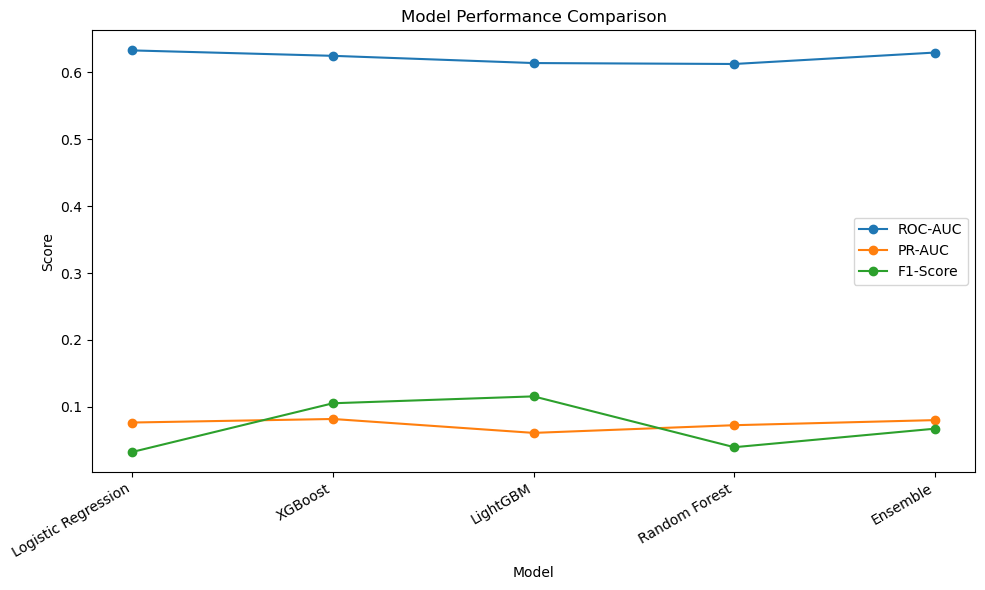

In [124]:
import pandas as pd
import matplotlib.pyplot as plt

# Create DataFrame
df = pd.DataFrame({
    "Model": [
        "Logistic Regression",
        "XGBoost",
        "LightGBM",
        "Random Forest",
        "Ensemble"
    ],
    "ROC-AUC": [0.6328, 0.6247, 0.6139, 0.6125, 0.6296],
    "PR-AUC":  [0.0765, 0.0818, 0.0610, 0.0725, 0.0801],
    "F1-Score":[0.0325, 0.1053, 0.1156, 0.0396, 0.0673]
})

# Plot
plt.figure(figsize=(10, 6))
plt.plot(df["Model"], df["ROC-AUC"], marker="o", label="ROC-AUC")
plt.plot(df["Model"], df["PR-AUC"], marker="o", label="PR-AUC")
plt.plot(df["Model"], df["F1-Score"], marker="o", label="F1-Score")

plt.title("Model Performance Comparison")
plt.xlabel("Model")
plt.ylabel("Score")
plt.xticks(rotation=30, ha="right")
plt.legend()
plt.tight_layout()
plt.show()


OBSERVATIONS:

The experimental results indicate that while Logistic Regression provides the best overall ranking ability (ROC-AUC), the XGBoost and LightGBM models are significantly more effective at identifying repeat customers (F1-Score). The Ensemble model successfully balanced these diverse approaches, providing a stable prediction set. For a business deployment where precision is key (e.g., spending budget on customer retention), XGBoost is the recommended model due to its superior PR-AUC



### SAVING MODELS FOR FUTURE TRAINING ###

In [ ]:

joblib.dump(xgb_pipe_final, 'clf_model_xgboost_optimized.pkl')

joblib.dump(rf_pipe, 'clf_model_random_forest.pkl')

joblib.dump(lr_final_pipe, 'clf_model_logistic_regression.pkl')

joblib.dump(ensemble_model, 'clf_model_ensemble_voter.pkl')


All 4 classification models have been saved successfully!
